<a href="https://colab.research.google.com/github/lupis30puc/yelp_bert_random_forest/blob/update-8/RF_BERT_feature_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [ ]:
!pip install treeinterpreter
#https://pypi.org/project/treeinterpreter/

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.8MB 5.9MB/s 
     |████████████████████████████████| 2.9MB 39.7MB/s 
     |████████████████████████████████| 890kB 42.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=f98a5f7b02f908382fc2dc3b074c2d2964ca5b23e765f379846affc859d144d7
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import string
import math

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

import time
import pickle
from treeinterpreter import treeinterpreter as ti
import joblib
from transformers import BertTokenizer
import torch

In [ ]:
# function so that the graphs look good 
def set_plotting_style():
  tw = 1.5
  rc = {'lines.linewidth': 2,
              'axes.labelsize': 18,
              'axes.titlesize': 21,
              'xtick.major' : 16,
              'ytick.major' : 16,
              'xtick.major.width': tw,
              'xtick.minor.width': tw,
              'ytick.major.width': tw,
              'ytick.minor.width': tw,
              'xtick.labelsize': 'large',
              'ytick.labelsize': 'large',
              'font.family': 'sans',
              'weight':'bold',
              'grid.linestyle': ':',
              'grid.linewidth': 1.5,
              'grid.color': '#ffffff',
              'mathtext.fontset': 'stixsans',
              'mathtext.sf': 'fantasy',
              'legend.frameon': True,
              'legend.fontsize': 12, 
            "xtick.direction": "in","ytick.direction": "in"}

  plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
  plt.rc('mathtext', fontset='stixsans', sf='sans')
  sns.set_style('ticks', rc=rc)
  sns.set_context('notebook', rc=rc)


## Initializing the RF model and the x and y values

In [ ]:
# load, no need to initialize the loaded_rf
rf_grid = joblib.load("/content/drive/MyDrive/Yelp/model_128_/rf_grid_not_1000.joblib")

In [ ]:
rf_grid.best_params_  # Parameter setting that gave the best results on the hold out data.
rf = rf_grid.best_estimator_ 
print(rf_grid.best_params_)

{'min_samples_leaf': 2, 'n_estimators': 400}


In [ ]:
x_train = pd.read_pickle('/content/drive/MyDrive/Yelp/model_128_/binary_train_rf_feb_02')
x_test = pd.read_pickle('/content/drive/MyDrive/Yelp/model_128_/binary_test_rf_feb_02')

In [ ]:
y_train = torch.load('/content/drive/MyDrive/Yelp/model_128_/pred_labels_train')
y_test = torch.load('/content/drive/MyDrive/Yelp/model_128_/pred_labels_test')

## Initializing BERT tokenizers and reviews **text**, features and ids

In [ ]:
# NO NEED FOR THE DATASET OR YES?
train_df = pd.read_pickle('/content/drive/MyDrive/Yelp/sample_train_10394.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/Yelp/sample_test_2599.pkl')

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
#train_df.head()

In [ ]:
with open('/content/drive/MyDrive/Yelp/model_128_/train_ids_128.pkl', 'rb') as f:
    train_ids = pickle.load(f)

with open('/content/drive/MyDrive/Yelp/model_128_/test_ids_128.pkl', 'rb') as d:
    test_ids = pickle.load(d)

In [ ]:
# launching the saved model tokenizer
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/Yelp/model_128_/tokenizer_128/')

In [ ]:
with open('/content/drive/MyDrive/Yelp/model_128_/feature_names_feb_03.pkl', 'rb') as f:
  feature_names = pickle.load(f)

In [ ]:
with open('/content/drive/MyDrive/Yelp/model_128_/unique_ids_feb_03.pkl', 'rb') as f:
  unique_ids = pickle.load(f)

In [ ]:
print(len(unique_ids), len(feature_names))

16563 16563


## Feature importances and contributions

In [ ]:
importance_rf = rf.feature_importances_

In [ ]:
feature_importance = pd.DataFrame({'ids': unique_ids, 'words': feature_names, 'imp': importance_rf})

In [ ]:
# sorting the df by importance and reseting the index
# feature_importance[['words', 'imp']].sort_values(by=['imp'], ascending=False)[:15]
feature_importance = feature_importance.sort_values(by=['imp'], ascending=False)
feature_importance.reset_index(drop = True, inplace = True)

In [ ]:
# top 15 words
feature_importance[:15] #words with important role 

,ids,words,imp
0,2307,great,0.035311
1,12090,delicious,0.018375
2,6429,amazing,0.016065
3,5409,worst,0.014470
4,5379,friendly,0.012964
5,2293,love,0.012546
6,9202,horrible,0.012401
7,6659,terrible,0.012306
8,2356,asked,0.012191
9,2409,told,0.011806


In [ ]:
%%time
#preds_400, bias_400, contributions_400 = ti.predict(random_f2, x_test)
    # takes around 20min to calculate, that's why it is saved!
# loading the preds and contributions
with open('/content/drive/MyDrive/Yelp/random_forest/contributions_1000.pkl', 'rb') as f:
  contribs_ts = pickle.load(f)

with open('/content/drive/MyDrive/Yelp/random_forest/pred_1000.pkl', 'rb') as f:
  preds_ts = pickle.load(f)

CPU times: user 132 ms, sys: 1.29 s, total: 1.42 s
Wall time: 10 s


In [ ]:
# number of reviews, and label array | number of reviews, number of features, array for each feature in each review
print(preds_ts.shape, contributions_ts.shape)

(2599, 2) (2599, 16563, 2)


## Creating a df of each category for the test set

In [ ]:
test_df.head()

,text,label,clean_text,category,length
0,Positives: \n- good location \n- staff reasona...,0,positives good location staff reasonably frien...,Shopping and Beauty Industry,66
1,"Very clean hotel.jacuzzi is very huge,shower a...",0,clean hotel jacuzzi huge shower bathroom huge ...,Hotel Industry,50
2,I walked in with my uncle one saturday to help...,1,walked uncle saturday help cpap machine met re...,Other Industries,38
3,We ordered two Chai lattes $8.00...one was luk...,0,ordered chai lattes lukewarm best cold,Restaurant Industry,6
4,My wife and I didn't feel welcome at all. The...,0,wife feel welcome director assistant director ...,Other Industries,103


In [ ]:
test_df['category'].value_counts().apply(lambda c: round(c / len(test_df) *100), print('Percentages:'))

Percentages:


Restaurant Industry             70
Shopping and Beauty Industry    11
Other Industries                10
Hotel Industry                   6
Events and Arts Industry         3
Name: category, dtype: object

(array([   0.,  200.,  400.,  600.,  800., 1000.]),
 <a list of 6 Text major ticklabel objects>)

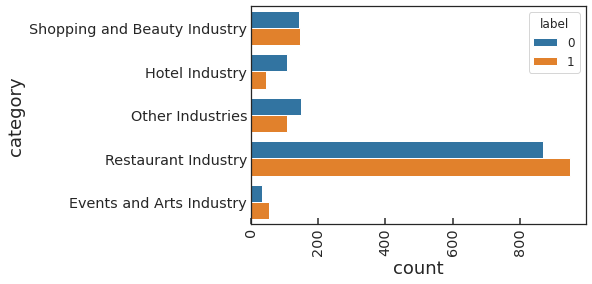

In [ ]:
set_plotting_style()
sns.countplot(y='category', hue='label', data=test_df)
plt.xticks(rotation=90)
# 0 is 'negative', 1 is 'positive'

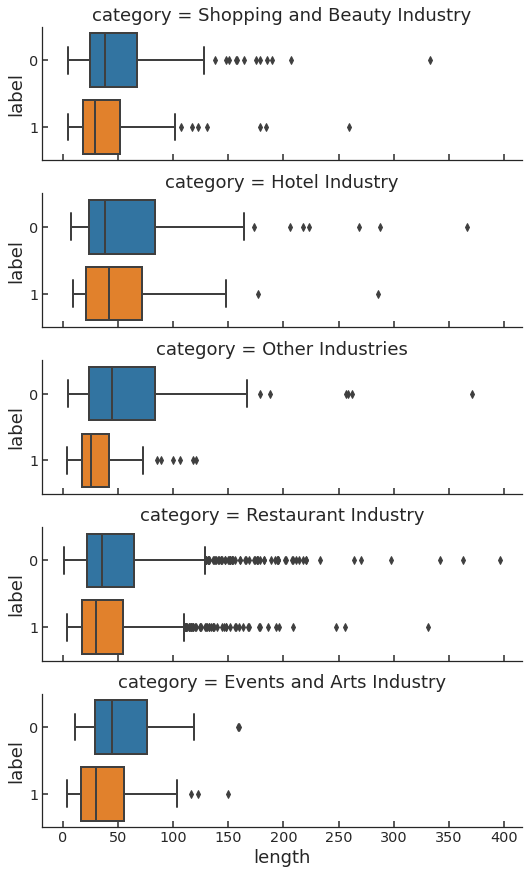

In [ ]:
# observing the length distribution per label and category
g = sns.catplot(x="length", y="label", row="category",
                 data=test_df,orient="h", height=2.4, aspect=3, palette="tab10", kind="box")

In [ ]:
# determining the categories samples
test_res = test_df[test_df['category'] == 'Restaurant Industry'].sample(frac=0.01, random_state=42)
test_beau= test_df[test_df['category'] == 'Shopping and Beauty Industry'].sample(frac=0.01, random_state=42)
test_other= test_df[test_df['category'] == 'Other Industries'].sample(frac=0.01, random_state=42)
test_hotel = test_df[test_df['category'] == 'Hotel Industry'].sample(frac=0.01, random_state=42)
test_art = test_df[test_df['category'] == 'Events and Arts Industry'].sample(frac=0.01, random_state=42)
print(len(test_res), len(test_beau), len(test_other), len(test_hotel), len(test_art))

18 3 3 2 1


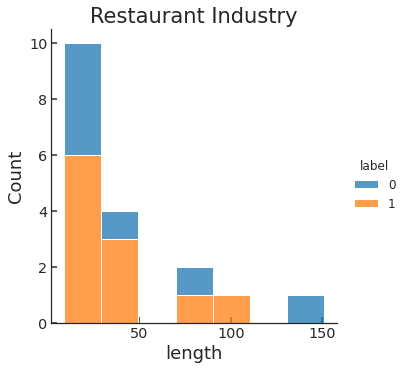

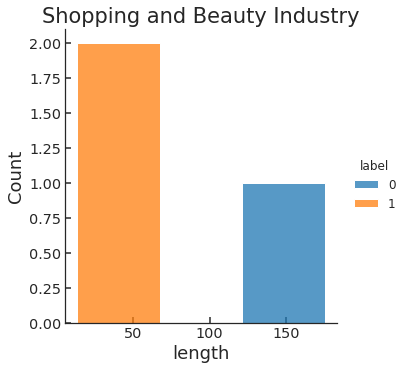

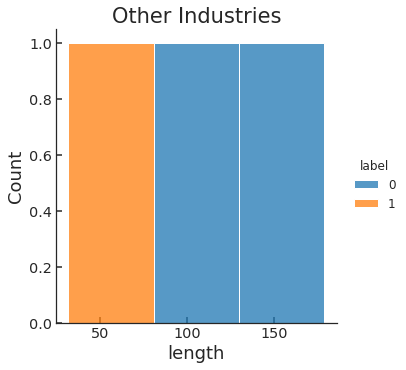

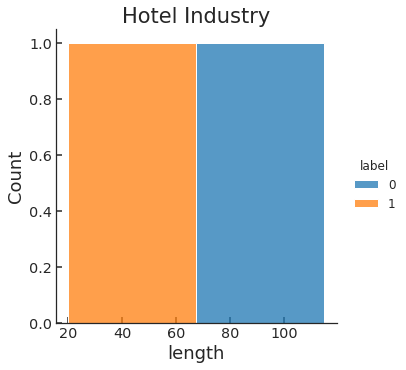

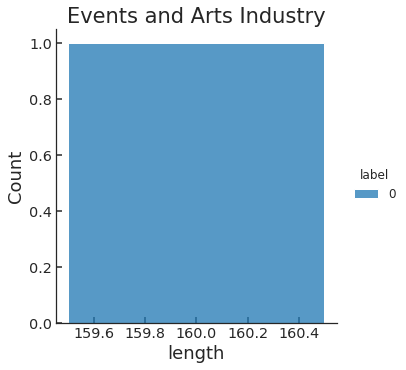

In [ ]:
test_samples = [test_res, test_beau, test_other, test_hotel, test_art]
for df in test_samples:
  plot =sns.displot(data=df, x='length', hue='label', multiple='stack')
  plt.title(df.category.max())

## Analyzing with contributions

### function for analyzing contributions

In [ ]:
import random
def present_sample_review(index, original_df, pred_labels, clean_text=True):
  """
  pred_label is an array
  original df has the columns: label and clean_text/ text

  """
  print("Selected Sample     : %d"%index)
  print("Actual Target Value : %s"%y_test.label[index])
  print("Predicted Value     : %s"%np.argmax(pred_labels[index]))
  if clean_text == True:
    print("" + "\nThe review is: " + "\n" + original_df.clean_text[index])
    print('' + '\nThe review has a length of ' + str(len(original_df.clean_text[index].strip().split(" "))) + ' words.')
  else:
    print("" + "\nThe review is: " + "\n" + original_df.text[index])
    print('' + '\nThe review has a length of ' + str(len(original_df.text[index].strip().split(" "))) + ' words.')

#print("Actual Target Value                      : %s"%y_test[0])
#print("Target Value As Per Treeinterpreter      : %s"%np.argmax(preds_400[0]))


In [ ]:
def print_negative():
  print(''+ '\nThe ' + str(len(negative)) + ' contributions for negative are: ')
  print(negative)

def print_positive():
  print(''+ '\nThe ' + str(len(positive)) + ' contributions for positive are: ')
  print(positive)

In [ ]:
def contributions_analysis(original_df, pred_labels, input_ids, features_df, contributions, print_analysis=True, clean_text=True, index=None):
  """
  contributions is an array
  clean_text=None

  print_analysis can be:
    -True (prints both negative and positive)
    -False (just return dictionaries or lists)
    -negative (prins only negative contributions)
    -positive (prints only positive contributions)

  Returns a dataframe with the negative and positive contributions of the relevant features for the observed review.
  """
  if index == None:
    review = random.randint(1, len(original_df))
  else: 
    review = index
  
  present_sample_review(review, original_df, pred_labels, clean_text) #it must take the predicted label from bert!

  #extracting only the relevant ids index. the ones that the observed review has
  review_ids = list(features_df[features_df['ids'].isin(input_ids[review])].index) 
  
  print('' + "\nFeature contributions:")
  # creating a dictionary of the contributions for the specific id on the observed review
  contribs = {}
  for i in review_ids:
    c = contributions[review][i] 
    feature = features_df['words'][i] 
    contribs[feature] = list(c)
  
  # creating a dataframe out of it 
  contrib_df = pd.DataFrame(data=contribs.values(), index = contribs.keys(), columns=["negative", "positive"])
  
  #obtaining the negative and positive contributions
  negative = contrib_df[contrib_df['positive'] <= 0].sort_values(by=['positive']) #ascending positive
  positive = contrib_df[contrib_df['positive'] > 0].sort_values(by=['positive'], ascending=False) #descending positive

  def print_negative():
    print(''+ '\nThe ' + str(len(negative)) + ' contributions for negative are: ')
    print(negative)

  def print_positive():
    print(''+ '\nThe ' + str(len(positive)) + ' contributions for positive are: ')
    print(positive)

  # determining what to print 
  if print_analysis == True:
    print_negative()
    print_positive()
  elif print_analysis == 'negative':
    print_negative()
    print(''+ '\nAnd there are ' + str(len(positive)) + ' contributions for positive. ')
  elif print_analysis == 'positive':
    print_positive()
    print(''+ '\nAnd there are ' + str(len(negative)) + ' contributions for negative. ')
  elif print_analysis == False:
    print('There are ' + str(len(negative)) + ' contributions for negative. ')
    print('There are ' + str(len(positive)) + ' contributions for positive. ')

  # inserting the predicted label at the end
  prediction = contrib_df[["negative", "positive"]].sum()
  contrib_df.loc["PREDICTION"] = np.argmax(prediction)

  return contrib_df

## running the analysis

In [ ]:
test_df.head(2)

,text,label,categories,clean_text
0,Positives: \n- good location \n- staff reasona...,0,"Nail Salons, Beauty & Spas, Day Spas",positives good location staff reasonably frien...
1,"Very clean hotel.jacuzzi is very huge,shower a...",0,"Wedding Planning, Event Planning & Services, B...",clean hotel jacuzzi huge shower bathroom huge ...


In [ ]:
test_df['categories'].head() 

0                 Nail Salons, Beauty & Spas, Day Spas
1    Wedding Planning, Event Planning & Services, B...
2                   Home Health Care, Health & Medical
3                                   Food, Coffee & Tea
4    Education, Local Services, Child Care & Day Ca...
Name: categories, dtype: object

In [ ]:
# .apply(lambda x : len(x.strip().split(" ")))
len(test_df.clean_text[0].strip().split(" "))

66

In [ ]:
len(list(feature_importance_1000[feature_importance_1000['ids'].isin(test_ids[0])].index))

71

In [ ]:
#random
z = contributions_analysis2(test_df, preds_1000, test_ids, feature_importance_1000, contributions_1000, print_analysis=False)

Predictions for random forest 1000 of 2 sample leaves and for a random review
Selected Sample     : 2260
Actual Target Value : 0
Predicted Value     : 1

The review is: 
options menu sounded good ordered hominy appetizer spicy good recommend chose pork chops entree sauce heavy chop tender alot fat wouldn order friend clams enjoyed ambiance nice waiter cool weren great conversation old friend dinner miss

The review has a length of 36 words.

Feature contributions:
There are 29 contributions for negative. 
There are 17 contributions for positive. 


In [ ]:
%%time
#specific
contri_462 = contributions_analysis(test_df, preds_400, test_ids, feature_importance_400, contributions_400, print_analysis=False, index=462)

Predictions for random forest 1000 of 2 sample leaves and for the review #462
Selected Sample     : 462
Actual Target Value : 1
Predicted Value     : 1

The review is: 
went sunday dinner kids excited going bobby flay restaurant wanted squid appetizer thought fishy apple blue cheese salad appetizer good small mains fabulous venison tender rich sauce pork tenderloin spicy rub seafood ciappino tipper prawns scallops grouper mussels garlic sweet potato tamale good sides baby carrots mashed potatoes good especially carrots reason stars appetizers good rest good value

The review has a length of 58 words.

Feature contributions:
There are 37 contributions for negative. 
There are 37 contributions for positive. 
CPU times: user 15 ms, sys: 39 µs, total: 15.1 ms
Wall time: 14.8 ms


## Function to make a df for the contributions of a random or specific review

How to analyze the samples for train and
 test???

In [ ]:
def create_contrbutions_df(contributions, review, features_df, input_ids):
  #extracting only the relevant ids index. the ones that the observed review has
  review_ids = list(features_df[features_df['ids'].isin(input_ids[review])].index) 

  #creating a dictionary of the contributions for the specific id on the observed review
  contribs = {}
  for i in review_ids:
    c = contributions[review][i] 
    feature = features_df['words'][i] 
    contribs[feature] = list(c)
  
  # creating a dataframe out of it 
  contrib_df = pd.DataFrame(data=contribs.values(), index = contribs.keys(), columns=["negative", "positive"])
  # inserting the predicted label at the end
  prediction = contrib_df[["negative", "positive"]].sum()
  contrib_df.loc["PREDICTION"] = np.argmax(prediction)
  return contrib_df

In [ ]:
test_res.index

Int64Index([ 814,  625, 2508,  979,  168, 1823, 1273, 2584, 1972, 1521,  826,
            1344, 1034,  497,  541,  392,  610, 2016],
           dtype='int64')

In [ ]:
import random
random_sample = random.choice(test_res.index) #obtaining a random review from the restaurant category
print("Selected Sample     : %d"%random_sample)
print("Actual Target Value : %s"%y_test[random_sample])
print("Predicted Value     : %s"%np.argmax(preds_400[random_sample]))

Selected Sample     : 2584
Actual Target Value : 1
Predicted Value     : 1


**TO TAKE INTO ACCOUNT: the y_test labels are different from the test_df labels**

Because y_test are the labels predicted by BERT and the test_df are the originals

In [ ]:
contrib_rest = create_contrbutions_df(contributions_400, random_sample, feature_importance, test_ids)
contrib_rest
contrib_rest[contrib_rest['positive'] > 0].sort_values(by=['positive'], ascending=False)[:10]

,negative,positive
PREDICTION,1.000000,1.000000
cong,-0.004479,0.004479
twice,-0.000783,0.000783
chill,-0.000621,0.000621
food,-0.000508,0.000508
great,-0.000497,0.000497
curry,-0.000241,0.000241
red,-0.000053,0.000053
creamy,-0.000053,0.000053
wait,-0.000044,0.000044


In [ ]:
c_rest = contributions_analysis(test_df, preds_400, test_ids, feature_importance, contributions_400, print_analysis=True, clean_text=True, index=random_sample)

NameError: ignored

In [ ]:
#negative contribs
contrib_rest[contrib_rest['positive'] <= 0].sort_values(by=['positive'])[:10]

,negative,positive
couldn,0.000577,-0.000577
came,0.000351,-0.000351
second,0.000055,-0.000055
menu,0.000051,-0.000051
bar,0.000012,-0.000012
save,0.000006,-0.000006
oyster,0.000000,0.000000
tuna,0.000000,0.000000
different,0.000000,0.000000
su,0.000000,0.000000


In [ ]:
# from: https://coderzcolumn.com/tutorials/machine-learning/treeinterpreter-interpreting-tree-based-models-prediction-of-individual-sample
%%time
contrib_df2 = create_contrbutions_df(contributions_400, random_sample, feature_importance_400, test_ids)
contrib_df2

CPU times: user 8.44 ms, sys: 14 µs, total: 8.45 ms
Wall time: 14 ms


In [ ]:
len(contrib_df2[contrib_df['positive'] > 0].sort_values(by=['positive'], ascending=False)) #len positive
# to get top positive features
#contrib_df2[contrib_df2['positive'] > 0].sort_values(by=['positive'], ascending=False)[:10]

38

In [ ]:
len(contrib_df2[contrib_df['positive'] <= 0].sort_values(by=['positive'])) #len negative
# to get top negative features
#contrib_df2[contrib_df2['positive'] <= 0].sort_values(by=['positive'])[:10]

37

## Notes:

 Global features and
Specific ones see if they match the reviews